# Lab 3

Написати програмну реалiзацiю алгоритму лiнiйної фiльтрацiї зображень згорткою. Навести результати роботи вашої програми для наступних фiльтрiв:

- згортка зображень - це процес додавання кожного елемента зображення до його сусідів, зважених ядром. Важливо зауважити, що виконувана матрична операція - згортка - це не звичайне множення, хоча й позначається *.
- згортка - це процес транспонування рядків і стовпчиків ядра з наступним множенням і додаванням.

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
file_path = "/Users/yurab/Desktop/IgromanYTS-basics-of-computer-vision/Lab1/image.png"
img = cv2.imread(file_path)

data = np.array(img)
data_list = img.tolist()

In [3]:
def apply_filter(image, kernel):
    image = np.array(image, dtype=np.float32)
    kernel = np.flip(kernel)  
    pad_h, pad_w = kernel.shape[0] // 2, kernel.shape[1] // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    result = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            result[i, j] = np.sum(region * kernel)

    return np.clip(result, 0, 255).astype(np.uint8)

1. Зсув зображення на 10 пiкселiв вправо та 20 вниз.

In [4]:
def moving(data):
    a = 10
    b = 20
    result = np.zeros(data.shape, dtype=np.uint8)

    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            X_plus = x + a
            Y_plus = y + b
            if 0 <= X_plus < data.shape[1] and 0 <= Y_plus < data.shape[0]:
                result[Y_plus, X_plus] = data[y, x]
    return result


In [12]:
img_shift = moving(data)
cv2.imwrite('shifted_image.png', img_shift)

True

2. Iнверсiя.


In [8]:
def inversion(input_image):

    filter_kernel = np.array([[0, 0, 0], [0, -1, 0], [0, 0, 0]])  
    filter_kernel = np.flipud(np.fliplr(filter_kernel)) 

    result_image = np.zeros_like(input_image, dtype=np.float64)
    padded_input = np.pad(input_image, ((filter_kernel.shape[0] // 2,), (filter_kernel.shape[1] // 2,)), mode='constant', constant_values=0)

    for row in range(input_image.shape[0]):
        for col in range(input_image.shape[1]):
            region = padded_input[row:row + filter_kernel.shape[0], col:col + filter_kernel.shape[1]]
            result_image[row, col] = np.sum(region * filter_kernel)

    return result_image.astype(np.uint8)

In [13]:
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) 

img_inversion = inversion(image)
cv2.imwrite('img_inversion.png', img_inversion)

True

3. Згладжування по Гауссу (розмiр фiльтра не менше 11х11).

$$ \text{PDF}(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x - \mu)^2}{2\sigma^2}} $$

In [14]:
def dnorm(value, mean=0, std_deviation=1):
    return (1 / (std_deviation * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((value - mean) / std_deviation) ** 2)

def gaussian_kernel(kernel_size, sigma=1, show=True):
    
    kernel_1D = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    for index in range(kernel_size):
        kernel_1D[index] = dnorm(kernel_1D[index], 0, sigma)
    
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
    kernel_2D /= kernel_2D.sum()  

    if show:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Gaussian Kernel")
        plt.colorbar()
        plt.show()
    return kernel_2D

def gaussian(input_image, kernel_size, sigma=1):

    filter_kernel = gaussian_kernel(kernel_size, sigma)
    padding_size = kernel_size // 2  
    
    output_image = np.zeros_like(input_image)

    for color_channel in range(input_image.shape[2]): 
        padded_image = np.pad(input_image[..., color_channel], ((padding_size, padding_size), (padding_size, padding_size)), mode='constant')
        
        for row in range(input_image.shape[0]):
            for col in range(input_image.shape[1]):
                region = padded_image[row:row + kernel_size, col:col + kernel_size]
                output_image[row, col, color_channel] = np.sum(region * filter_kernel)

    return output_image

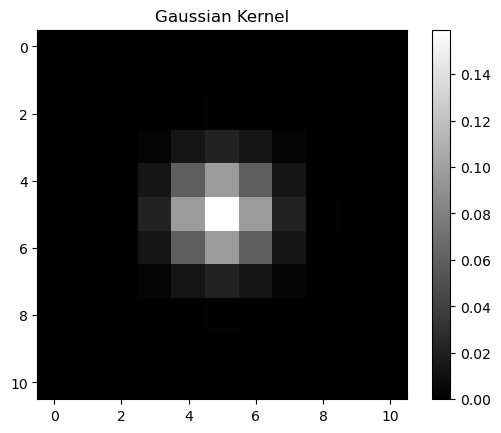

True

In [15]:
gaussian_img = gaussian(img, 11, sigma=1)
cv2.imwrite('img_gaussian.png', gaussian_img)

4. Розмиття "рух по дiагоналi"(розмiр фiльтра не менше 7х7).


In [16]:
def diagonal_kernel(kernel_size):
    kernel_matrix = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    for index in range(kernel_size):
        kernel_matrix[index, index] = 1.0  
    return kernel_matrix / kernel_size  

def diagonal_motion(input_image, kernel_size):
    
    kernel_matrix = diagonal_kernel(kernel_size)
    padding_size = kernel_size // 2
    blurred_image = np.zeros_like(input_image)

    for color_channel in range(input_image.shape[2]):  
        padded_image = np.pad(input_image[..., color_channel], ((padding_size, padding_size), (padding_size, padding_size)), mode='constant')
        
        for row in range(input_image.shape[0]):
            for col in range(input_image.shape[1]):
                region = padded_image[row:row + kernel_size, col:col + kernel_size]
                blurred_image[row, col, color_channel] = np.sum(region * kernel_matrix)

    return blurred_image

In [17]:
img_diagonal = diagonal_motion(img, 8)
cv2.imwrite('img_diagonal_motion.png', img_diagonal)

True

5. Пiдвищення рiзкостi.

In [18]:
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

def sharpening(input_image, kernel):
    padding_size = kernel.shape[0] // 2
    padded_image = np.pad(input_image, ((padding_size, padding_size), (padding_size, padding_size), (0, 0)), mode='constant')
    convolved_image = np.zeros_like(input_image)

    for row in range(input_image.shape[0]):
        for col in range(input_image.shape[1]):
            region = padded_image[row:row + kernel.shape[0], col:col + kernel.shape[1], :]
            for color_channel in range(3):  
                convolved_image[row, col, color_channel] = np.clip(np.sum(region[:, :, color_channel] * kernel), 0, 255)

    return convolved_image.astype(np.uint8)

In [19]:
sharpen_img = sharpening(img, sharpen_kernel)
cv2.imwrite('sharpen_img.png', sharpen_img)

True

6. Фiльтр Собеля (напрямок не важливий)

$$ \text{Magnitude} = \sqrt{(\text{grad}_x)^2 + (\text{grad}_y)^2} $$

In [20]:
def sobel_filter(input_image):

    horizontal_kernel = np.array([[-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]])
    
    vertical_kernel = np.array([[1, 2, 1],
                                [0, 0, 0],
                                [-1, -2, -1]])

    height, width, _ = input_image.shape
    padding_size = 1
    padded_image = np.pad(input_image, ((padding_size, padding_size), (padding_size, padding_size), (0, 0)), mode='constant')
    
    result_image = np.zeros((height, width, 3))

    for color_channel in range(3):  
        for row in range(height):
            for col in range(width):
                
                region = padded_image[row:row + 3, col:col + 3, color_channel]
                grad_x = np.sum(region * horizontal_kernel)
                grad_y = np.sum(region * vertical_kernel)
                result_image[row, col, color_channel] = np.clip(np.sqrt(grad_x**2 + grad_y**2), 0, 255)

    return result_image.astype(np.uint8)

In [21]:
sobel_result = sobel_filter(img)
cv2.imwrite('img_sobel.png', sobel_result)

True

7. Фiльтр границi

In [22]:
def border_detection(input_image):

    filter_kernel = np.array([[-1, -1, -1],
                               [-1,  8, -1],
                               [-1, -1, -1]])
    
    height, width, _ = input_image.shape
    padding_size = 1
    padded_image = np.pad(input_image, ((padding_size, padding_size), (padding_size, padding_size), (0, 0)), mode='constant')
    
    result_image = np.zeros_like(input_image)

    for color_channel in range(3):  
        for row in range(height):
            for col in range(width):

                region = padded_image[row:row + 3, col:col + 3, color_channel]
                result_image[row, col, color_channel] = np.clip(np.sum(region * filter_kernel), 0, 255)

    return result_image.astype(np.uint8)

In [23]:
img_bord = border_detection(img)
cv2.imwrite('img_bord.png', img_bord)

True

8. Ембос фільтр

In [24]:
def emboss_effect(input_image):
    kernel_matrix = np.array([[-1, -1, -1, -1,  0],
                               [-1, -1, -1,  0,  1],
                               [-1, -1,  0,  1,  1],
                               [-1,  0,  1,  1,  1],
                               [ 0,  1,  1,  1,  1]])
    
    height, width, _ = input_image.shape
    padding_size = kernel_matrix.shape[0] // 2

    padded_image = np.pad(input_image, ((padding_size, padding_size), (padding_size, padding_size), (0, 0)), mode='constant')

    filtered_image = np.zeros_like(input_image, dtype=np.float64)

    for row in range(height):
        
        for col in range(width):
            region = padded_image[row:row + 5, col:col + 5, :]
            for color_channel in range(3):  
                filtered_image[row, col, color_channel] = np.clip(np.sum(region[:, :, color_channel] * kernel_matrix), 0, 255)

    return filtered_image.astype(np.uint8)  

In [25]:
emboss_img = emboss_effect(img)
cv2.imwrite('emboss_img.png', emboss_img)

True